<a href="https://colab.research.google.com/github/SEONGJAE-YOO/Kaggle/blob/main/Bag_of_Words_Meets_Bags_of_Popcorn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Bag of Words Meets Bags of Popcorn¶

https://www.kaggle.com/c/word2vec-nlp-tutorial

In [71]:
!git clone https://github.com/SEONGJAE-YOO/Kaggle.git

Cloning into 'Kaggle'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


# 개요
NLP(자연어처리)는 텍스트 문제에 접근하기 위한 기술집합이다. 이 튜토리얼에서는 IMDB 영화 리뷰를 로딩하고 정제하고 간단한 BOW(Bag of Words) 모델을 적용하여 리뷰가 추천인지 아닌지에 대한 정확도를 예측한다.

# BOW(bag of words)
가장 간단하지만 효과적이라 널리쓰이는 방법
장, 문단, 문장, 서식과 같은 입력 텍스트의 구조를 제외하고 각 단어가 이 말뭉치에 얼마나 많이 나타나는지만 헤아린다.
구조와 상관없이 단어의 출현횟수만 세기 때문에 텍스트를 담는 가방(bag)으로 생각할 수 있다.
BOW는 단어의 순서가 완전히 무시 된다는 단점이 있다. 예를 들어 의미가 완전히 반대인 두 문장이 있다고 하다.
it's bad, not good at all.
it's good, not bad at all.
위 두 문장은 의미가 전혀 반대지만 완전히 동일하게 반환된다.
이를 보완하기 위해 n-gram을 사용하는 데 BOW는 하나의 토큰을 사용하지만 n-gram은 n개의 토큰을 사용할 수 있도록 한다.

Bag-of-words model - Wikipedia

In [9]:
from google.colab import drive

drive.mount('/content/drive/')

 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [10]:
import pandas as pd

"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며 
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""
# QUOTE_MINIMAL (0), QUOTE_ALL (1), 
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

# 레이블인 sentiment 가 있는 학습 데이터
train = pd.read_csv('/content/drive/MyDrive/kaggle/data/labeledTrainData.tsv', delimiter='\t', quoting=3)
# 레이블이 없는 테스트 데이터
test = pd.read_csv('/content/drive/MyDrive/kaggle/data/testData.tsv', delimiter='\t', quoting=3)
train.shape

(25000, 3)

In [11]:
train.tail(3)

,id,sentiment,review
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


In [12]:
test.shape

(25000, 2)

In [13]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [14]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [15]:
test.columns.values

array(['id', 'review'], dtype=object)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [17]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [18]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [19]:
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

# 데이터 정제 Data Cleaning and Text Preprocessing
기계가 텍스트를 이해할 수 있도록 텍스트를 정제해 준다.

신호와 소음을 구분한다. 아웃라이어데이터로 인한 오버피팅을 방지한다.

BeautifulSoup(뷰티풀숩)을 통해 HTML 태그를 제거
정규표현식으로 알파벳 이외의 문자를 공백으로 치환
NLTK 데이터를 사용해 불용어(Stopword)를 제거
어간추출(스테밍 Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출
텍스트 데이터 전처리 이해하기
(출처 : 트위터 한국어 형태소 분석기)

정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)

한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ
토큰화 tokenization

한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle
어근화 stemming (입니다 -> 이다)

한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle
어구 추출 phrase extraction

한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시
Introductory Presentation: Google Slides

뷰티풀숩이 설치되지 않았다면 우선 설치해 준다.
!pip install BeautifulSoup4

In [20]:
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [21]:
#정규표현식을 사용해서 특수문자를 제거
import re
#소문자와 대문자가 아닌 것은 공백으로 대체한다
letters_only = re.sub('[^a-zA-Z]',' ',example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [22]:
#모두 소문자로 변환한다.
lower_case = letters_only.lower()
#문자로 나눈다 => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

- 불용어 제거(Stopword Removal)

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다

In [23]:
# 텍스트 데이터 전처리를 위해 다음을 다운로드 해야함
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [24]:
from nltk.corpus import stopwords

In [25]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [26]:
# stopwords 를 제거한 토큰들 
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

# 스테밍(어간추출, 형태소 분석)
출처 : 어간 추출 - 위키백과, 우리 모두의 백과사전

어간 추출(語幹 抽出, 영어: stemming)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
"message", "messages", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
stemming(형태소 분석): 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다

In [27]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [28]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [29]:
#처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [30]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]
# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

- Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 예를 들어 동음이의어가 문맥에 따라 다른 의미를 갖는데

1) *배*가 맛있다. 

2) *배*를 타는 것이 재미있다. 

3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다.
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다. 영어에서 meet는 meeting으로 쓰였을 때 회의를 뜻하지만 meet 일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다.


In [31]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]
# 처리 후 단어
words[:10]

fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

# 문자열 처리 

In [32]:
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [33]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [34]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [35]:
clean_train_reviews = []

for i in range(0, num_reviews):
    clean_train_reviews.append( review_to_words(train['review'][i]))

clean_train_reviews = []
for i in range(0, num_reviews):
    if (i + 1)%5000 == 0:
        print('Review {} of {} '.format(i+1, num_reviews))
    clean_train_reviews.append(review_to_words(train['review'][i]))
    


Review 5000 of 25000 
Review 10000 of 25000 
Review 15000 of 25000 
Review 20000 of 25000 
Review 25000 of 25000 


In [36]:
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [37]:
%time clean_train_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)

CPU times: user 457 ms, sys: 197 ms, total: 654 ms
Wall time: 1min 5s


In [38]:
%time clean_test_reviews = apply_by_multiprocessing(\
    test['review'], review_to_words, workers=4)

CPU times: user 422 ms, sys: 199 ms, total: 622 ms
Wall time: 1min 3s


# 워드 클라우드
단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는 게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [39]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline 설정을 해주어야지만 노트북 안에 그래프가 디스플레이 된다.
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

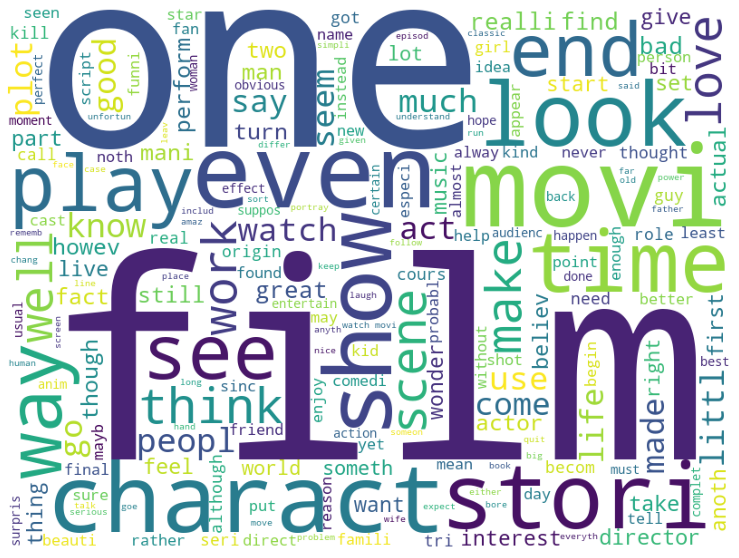

CPU times: user 21.4 s, sys: 971 ms, total: 22.4 s
Wall time: 22.4 s


In [40]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_train_reviews))


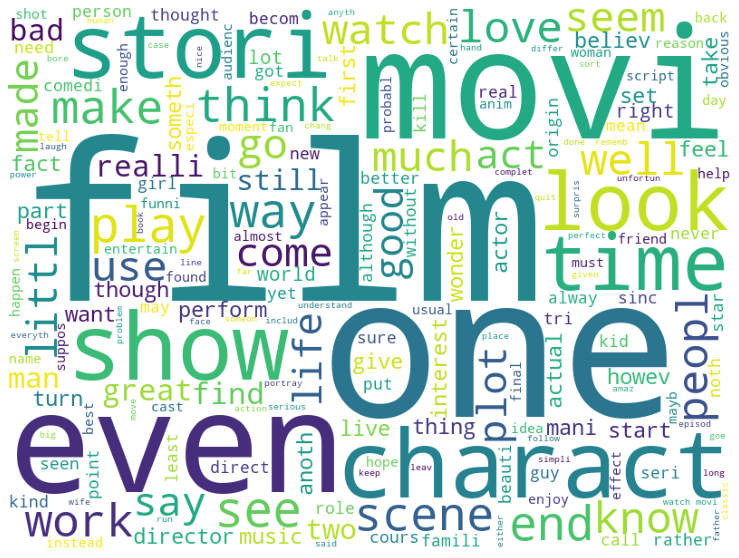

CPU times: user 21.7 s, sys: 691 ms, total: 22.4 s
Wall time: 22.3 s


In [41]:
# 테스트 데이터의 모든 단어에 대한 워드 클라우드를 그려본다
%time displayWordCloud(' '.join(clean_train_reviews))

In [42]:
# 단어 수
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))

In [43]:
#AttributeError: 'list' object has no attribute 'apply' 해결방안
count_words_f = lambda x: len(str(x).split())

train['num_words'] = list(map(count_words_f, clean_train_reviews))

count_uniq_words_f = lambda x: len(set(str(x).split()))

train['num_uniq_words'] = list(map(count_uniq_words_f, clean_train_reviews))

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              25000 non-null  object
 1   sentiment       25000 non-null  int64 
 2   review          25000 non-null  object
 3   num_words       25000 non-null  int64 
 4   num_uniq_words  25000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 976.7+ KB


In [45]:
# 첫 번째 리뷰에 
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

리뷰별 단어 평균 값: 119.52356
리뷰별 단어 중간 값: 119.52356
리뷰별 고유 단어 평균 값: 94.05756
리뷰별 고유 단어 중간 값: 74.0


Text(0.5, 1.0, '리뷰별 고유한 단어 수 분포')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48624 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backen

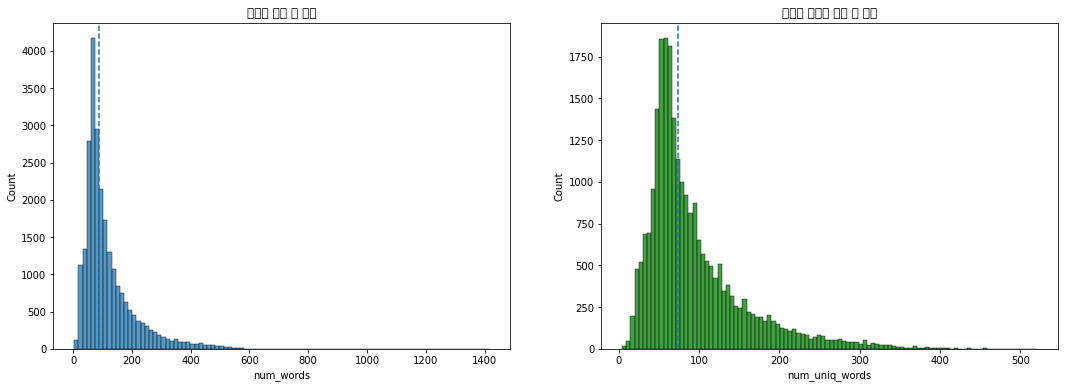

In [46]:
import seaborn as sns

plt.rc('font', family='Malgun Gothic') #글자 깨짐 방지

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18,6)
print('리뷰별 단어 평균 값:',train['num_words'].mean())
print('리뷰별 단어 중간 값:', train['num_words'].mean())
sns.histplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

print('리뷰별 고유 단어 평균 값:',train['num_uniq_words'].mean())
print('리뷰별 고유 단어 중간 값:',train['num_uniq_words'].median())
sns.histplot(train['num_uniq_words'], bins=100,color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰별 고유한 단어 수 분포')

# 사이킷런의 CountVectorizer를 통해 피처 생성

정규표현식을 사용해 토큰을 추출한다.

모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.

의미없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.

min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=20000, min_df=2,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

- sklearn.pipeline.Pipeline
1. workfolw를 자동화 시킬 수 있다
2. data leakage 문제를 최소화 시킬 수 있다
3. 선형적 순서로 데이터를 transform하고 모델 트레이닝 및 평가 까지 파이프라인으로 가능하다.


In [48]:
# 여기에서는 하나의 과정만 묶어주어 pipeline이 불필요 할 수도 있습니다.
# pipeline은 feature engineering의 여러 과정을 묶어 줄 때 사용합니다.
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [49]:
%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

CPU times: user 30.5 s, sys: 740 ms, total: 31.3 s
Wall time: 31.2 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [50]:
train_data_features.shape

(25000, 20000)

In [51]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [52]:
#벡터화 된 피처를 확인해 봄
import numpy as np
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab,dist):
    print(count,tag)
    
pd.DataFrame(dist,columns=vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,abe,abhay,abid,abigail,abil,abil make,abl,abl get,abl make,abl see,abl watch,abli,aboard,abomin,aborigin,abort,abound,abraham,abraham lincoln,abroad,abrupt,absenc,absent,absolut,absolut aw,absolut brilliant,absolut hilari,absolut horribl,absolut love,absolut noth,...,yuen,yugoslavia,yup,yuppi,yuzna,yvonn,zabriski,zabriski point,zach,zack,zane,zani,zatoichi,zealand,zelah,zelah clark,zelda,zenia,zero,zero day,zero star,zeta,zeta jone,zhang,zip,zizek,zodiac,zodiac killer,zoe,zombi,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,24,28,28,26,562,25,1259,53,32,54,35,27,37,83,69,92,63,93,29,38,136,118,83,1850,29,35,42,23,93,154,...,21,28,26,32,25,25,40,36,22,21,70,38,33,47,43,34,28,31,390,44,32,38,37,37,23,85,45,26,27,1331,23,52,37,89,161,31,71,59,40,23


In [53]:
pd.DataFrame(train_data_features[:10].toarray(), columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,abe,abhay,abid,abigail,abil,abil make,abl,abl get,abl make,abl see,abl watch,abli,aboard,abomin,aborigin,abort,abound,abraham,abraham lincoln,abroad,abrupt,absenc,absent,absolut,absolut aw,absolut brilliant,absolut hilari,absolut horribl,absolut love,absolut noth,...,yuen,yugoslavia,yup,yuppi,yuzna,yvonn,zabriski,zabriski point,zach,zack,zane,zani,zatoichi,zealand,zelah,zelah clark,zelda,zenia,zero,zero day,zero star,zeta,zeta jone,zhang,zip,zizek,zodiac,zodiac killer,zoe,zombi,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 랜덤 포레스트
랜덤 포레스트의 가장 핵심적인 특징은 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성된다는 점이다. 이 특징은 각 트리들의 예측(prediction)들이 비상관화(decorrelation) 되게하며, 결과적으로 일반화(generalization) 성능을 향상시킨다. 또한, 임의화(randomization)는 포레스트가 노이즈가 포함된 데이터에 대해서도 강하게 만들어 준다.

In [54]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2018, verbose=0,
                       warm_start=False)

In [55]:
%time forest = forest.fit(train_data_features, train['sentiment'])

CPU times: user 1min 25s, sys: 164 ms, total: 1min 25s
Wall time: 44 s


In [56]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_data_features, \
    train['sentiment'], cv=10, scoring='roc_auc'))
score

CPU times: user 13.6 s, sys: 1.54 s, total: 15.2 s
Wall time: 6min 26s


0.92761104

# 예측

In [57]:
# 위에서 정제해준 리뷰의 첫 번째 데이터를 확인
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [58]:
# 테스트 데이터를 벡터화 함
%time test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

CPU times: user 8.12 s, sys: 68.9 ms, total: 8.19 s
Wall time: 8.2 s


In [59]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [60]:
# 벡터화 된 단어로 숫자가 문서에서 등장하는 횟수를 나타낸다
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
# 벡터화 하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names()
vocab[8], vocab[2558], vocab[2559], vocab[2560]

('abc', 'charact person', 'charact play', 'charact plot')

In [64]:
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0])

# 캐글 제출을 위해 예측결과 저장

In [65]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",1
4,"""12128_7""",1


In [67]:
output.to_csv('/content/drive/MyDrive/kaggle/data/tutorial_1_BOW_{0:.5f}.csv'.format(score), index=False, quoting=3)

In [68]:
output_sentiment = output['sentiment'].value_counts()
print(np.abs(output_sentiment[0] - output_sentiment[1]))
output_sentiment

108


0    12554
1    12446
Name: sentiment, dtype: int64

# Train, Test의 감정분류 결과 값 비교


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


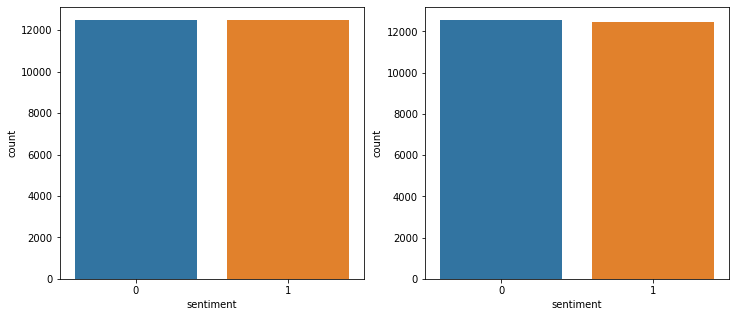

In [69]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

# 캐글 제출 결과

In [70]:
# 파라메터를 조정해 가며 점수를 조금씩 올려본다.

# uni-gram 사용 시 캐글 점수 0.84476
print(436/578)
# tri-gram 사용 시 캐글 점수 0.84608
print(388/578)
# 어간추출 후 캐글 점수 0.84780
print(339/578)
# 랜덤포레스트의 max_depth = 5 로 지정하고
# CountVectorizer의 tokenizer=nltk.word_tokenize 를 지정 후 캐글 점수 0.81460
print(546/578)
# 랜덤포레스트의 max_depth = 5 는 다시 None으로 변경
# CountVectorizer max_features = 10000개로 변경 후 캐글 점수 0.85272
print(321/578)
# CountVectorizer의 tokenizer=nltk.word_tokenize 를 지정 후 캐글 점수 0.85044
print(326/578)
# CountVectorizer max_features = 10000개로 변경 후 캐글 점수 0.85612
print(305/578)
# 0.85884
print(296/578)

print(310/578)

0.754325259515571
0.671280276816609
0.5865051903114187
0.9446366782006921
0.5553633217993079
0.5640138408304498
0.527681660899654
0.5121107266435986
0.5363321799307958
